<img src="resources/cropped-SummerWorkshop_Header.png">  

<h1 align="center">Workshop SWDB 2024 </h1> 
<h3 align="center">Day 3 2024 - Neuron Morphology</h3> 
<h3 align="center">Notebook 3: EM Connectomics</h3> 

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
   
<b> Electron Microscopy (EM) data enables morphological reconstruction of neurons and detection of their synaptic connectivity </b>. The <a href=https://www.microns-explorer.org/cortical-mm3>MICrONS dataset </a> is one of the largest datasets currently available spanning all layers of visual cortex. We will be using this dataset to query the connectivity between the excitatory neurons in the visual cortex. The exercises will cover the connectivity with inhibitory neurons. 

    
<em> Note on the data: </em> To make our lifes easier, we already queried the necessary data from the database and made it available as files that can be readily read with pandas. The entire dataset is hosted using the <a href=https://caveconnectome.github.io/sections/cave_overview.html> Connectome Annotation Versioning Engine (CAVE) </a>. A separate notebook shows how to use CAVE and how the files used in this notebook were created. 
    
    
</div>

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from os.path import join as pjoin

import skeleton_plot as skelplot
import meshparty
import cloudvolume

import sys
sys.path.append("..") # to access utils folder
from utils.skeleton_loading_utils import load_cv_skeleton

%matplotlib inline

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
This cell sets up a variable called `data_root` that you should use in any code below to access the dataset in question (e.g. paths to manifest files for the SDK should be made relative to this variable).
</div>

In [2]:
import platform
platstring = platform.platform()

if ('Darwin' in platstring) or ('macOS' in platstring):
    # macOS 
    data_root = "/Volumes/Brain2024/anatomy/"
elif 'Windows'  in platstring:
    # Windows (replace with the drive letter of USB drive)
    data_root = "E:/anatomy/"
elif ('amzn2' in platstring):
    # then on AWS
    data_root = "/data/"
else:
    # then your own linux platform
    # EDIT location where you mounted hard drive
    data_root = "/media/$USERNAME/Brain2024/anatomy/"

In [3]:
# Initialize cloud volume to access the EM skeletons
cv_obj = cloudvolume.CloudVolume(f"file://{data_root}/em_minnie65_v1078") 

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

    
## Proofreading information


Proofreading is necessary to obtain accurate reconstructions of a cell. In the MICrONS dataset, the general rule is that dendrites onto cells with a cell body are sufficiently proofread to trust synaptic connections onto a cell. Axons on the other hand require so much proofreading that only ~1,200 cells have proofread axons, 600 of which used a strategy that did not fully extend the axon (`axon_column_truncated`).
    
    
</div>

In [4]:
proof_df = pd.read_feather(pjoin(data_root,"microns1078","proofread_axons_microns_1078.feather"))

In [5]:
proof_columns = ['id',
 'pt_root_id',
 'status_dendrite',
 'status_axon', 
 'strategy_dendrite',
 'strategy_axon',
 'pt_position_x',
 'pt_position_y',
 'pt_position_z']
proof_df[proof_columns].head()

,id,pt_root_id,status_dendrite,status_axon,strategy_dendrite,strategy_axon,pt_position_x,pt_position_y,pt_position_z
0,11,864691135617152361,t,t,dendrite_extended,axon_partially_extended,740608.0,741376.0,850200.0
1,12,864691136090326071,t,t,dendrite_extended,axon_fully_extended,768320.0,760256.0,891880.0
2,13,864691135082864887,t,t,dendrite_extended,axon_interareal,1214636.0,665048.0,693960.0
3,14,864691136195284556,t,t,dendrite_extended,axon_fully_extended,692736.0,869888.0,877160.0
4,15,864691135565870679,t,t,dendrite_clean,axon_fully_extended,737536.0,435584.0,870200.0


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

Every annotation table has at least one set of position columns (here: `pt_position_{x,y,z}`) which serves as anchor to the segmentation. These positions are automatically associated to the segmentation using `pt_root_id`s which can be thought of segment or cell IDs.

This contains proofreading information for all neurons with proofread axons. We distinguish with what goal a proofreader proofread an axon; see <a href=https://www.microns-explorer.org/manifests/mm3-proofreading> this website </a>for a detailed overview.
    
</div>

In [6]:
proof_df["strategy_axon"].value_counts()

strategy_axon
axon_column_truncated      598
axon_partially_extended    341
axon_interareal            146
axon_fully_extended         77
Name: count, dtype: int64

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

Using the plotting logic introduced in the first notebook, we will start by visualizing an individual neuron. Over the course of this notebook we will annotate this neuron with increasingly more detailed synaptic connectivity.

</d>

In [7]:

def plot_skeleton(sk: meshparty.skeleton.Skeleton):
    """Plots a skeleton.
    
    Args:
        sk: meshparty skeleton
        
    Returns: 
        ax: plot axes
    """
    fig, ax = plt.subplots(figsize=(7, 10))
    skelplot.plot_tools.plot_skel(
        sk,
        ax=ax,
        line_width = 1,
        plot_soma = True,
        invert_y = True,
        x="x",
        y="y",
    )

    ax.spines['right'].set_visible(False) 
    ax.spines['left'].set_visible(False) 
    ax.spines['top'].set_visible(False) 
    ax.spines['bottom'].set_visible(False)
    ax.axis('off')
    
    return ax

In [8]:
root_id = proof_df.iloc[2]["pt_root_id"]
sk = load_cv_skeleton(root_id, cv_obj)

<Axes: >

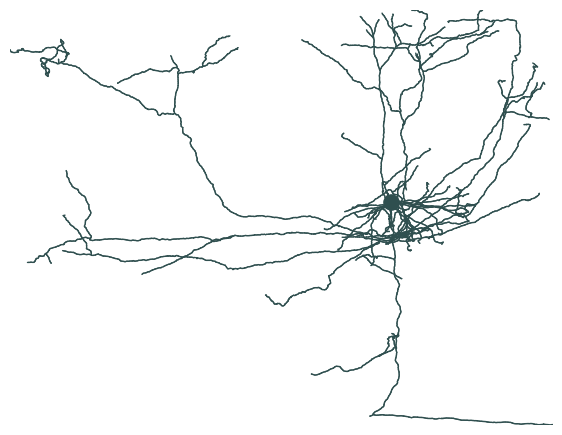

In [9]:
plot_skeleton(sk)

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

## Synaptic connectivity

Next, we will add synaptic connections to this neuron. We load the prepared table with the synaptic connectivity

This table has a number of columns, we will highlight the most important

<strong>id</strong>: a unique ID for each synapse

<strong>pre_pt_root_id</strong>: the segmentation ID of the pre-synaptic compartment

<strong>post_pt_root_id</strong>: the segmentation ID of the post-synaptic compartment

<strong>size</strong>: a measure of the synapse size  (the number of 4,4,40 nm voxels in the synapse mask) best available metric of synaptic weight

<strong>ctr_pt_position_{x,y,z}</strong>: the location of the synapse in the cleft, stored here in nanometers

<strong>pre_pt_position_{x,y,z}</strong>: a point just in the presynaptic compartment of synapse (used to lookup pre_root_id), stored here in nanometers

<strong>post_pt_position_{x,y,z}</strong>: a point just in the postsynaptic compartment of synapse (used to lookup post_pt_root_id), stored here in nanomaters

Other columns that are not very relevant for you..

<strong>created</strong>: when this synapse was uploaded
    
<strong>superceded_id</strong>: who this annotation was replaced by (no synapses have been)
    
<strong>valid</strong>: did annotation pass internal data QC check

</d>

In [10]:
proof_syn_table = pd.read_feather(pjoin(data_root,"microns1078", "syn_proofread_axons_all_microns_1078.feather"))
proof_syn_table.shape

(5568538, 18)

In [11]:
proof_columns = ['id',
'ctr_pt_position_x', 
'ctr_pt_position_y', 
'ctr_pt_position_y',
'size',
'pre_pt_root_id', 
'post_pt_root_id']
proof_syn_table[proof_columns].head()

,id,ctr_pt_position_x,ctr_pt_position_y,ctr_pt_position_y,size,pre_pt_root_id,post_pt_root_id
0,228711288,880584.0,529360.0,529360.0,2984,864691135946980644,864691135182553602
1,117425064,610504.0,486128.0,486128.0,2988,864691135855890478,864691136385578623
2,205635390,827780.0,549488.0,549488.0,2812,864691136025099065,864691135976624707
3,206366790,829580.0,669948.0,669948.0,9560,864691135759685966,864691135082749175
4,144046168,671552.0,417872.0,417872.0,1928,864691135759685966,864691133879805766


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

The synapse table contains snapses pre- and postsynaptic of all neurons in the proofreading table. This function provides filtering logic to extract synapses that belong to a specific set of neurons. 

</d>

In [12]:
def filter_synapse_table(synapse_table: pd.DataFrame, pre_root_ids=None, post_root_ids=None):   
    """Filter synapse table by pre and post root ids.

    Args:
        synapse_table: synapse table with pre_pt_root_ids and post_pt_root_ids as pd.DataFrame
        pre_root_ids: np.ndarray, list or pd.Series if root_ids to filter on the presynaptic side
        post_root_ids: np.ndarray, list or pd.Series if root_ids to filter on the postsynaptic side

    Returns:
        synapse_table: filtered synapse table
    """
    
    if pre_root_ids is not None:
        assert isinstance(pre_root_ids, (np.ndarray, list, pd.core.series.Series)), f"IDs have to be of type np.ndarray, list or pd.Series; got {type(pre_root_ids)}"
        pre_m = np.isin(synapse_table["pre_pt_root_id"], pre_root_ids)
    else:
        pre_m = np.ones(len(synapse_table), dtype=bool)
        
    if post_root_ids is not None:
        assert isinstance(post_root_ids, (np.ndarray, list, pd.core.series.Series)), f"IDs have to be of type np.ndarray, list or pd.Series; got {type(pre_root_ids)}"
        post_m = np.isin(synapse_table["post_pt_root_id"], post_root_ids)
    else:
        post_m = np.ones(len(synapse_table), dtype=bool)
        
    return synapse_table[pre_m & post_m]

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

We extract all synapses that our neuron of interest makes onto other neurons in the dataset by filtering on the presynaptic side:

</d>

In [13]:
pre_syns = filter_synapse_table(proof_syn_table, pre_root_ids=[root_id])

<Axes: xlabel='pre_pt_position_x', ylabel='pre_pt_position_y'>

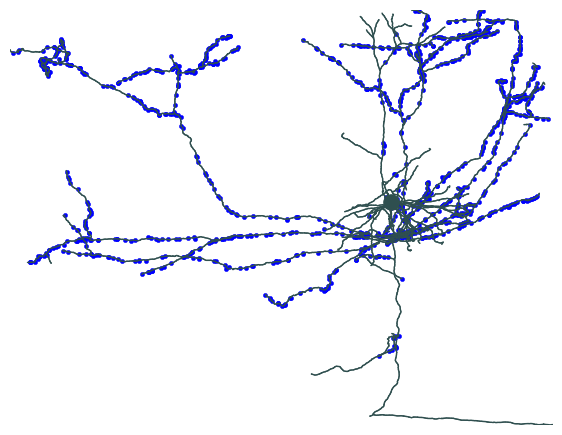

In [14]:
ax = plot_skeleton(sk)

sns.scatterplot(data=pre_syns, x="pre_pt_position_x", y="pre_pt_position_y", 
                s=10, color="b", ax=ax, edgecolor=None) 


<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p><b>Task 1:</b> Use the filter function above to create a dataframe of all postsynaptic synapses and create a version of the plot above that includes these postsynaptic synapses. 
    
</div>

In [15]:
post_syns = filter_synapse_table(proof_syn_table, post_root_ids=[root_id])

<Axes: xlabel='pre_pt_position_x', ylabel='pre_pt_position_y'>

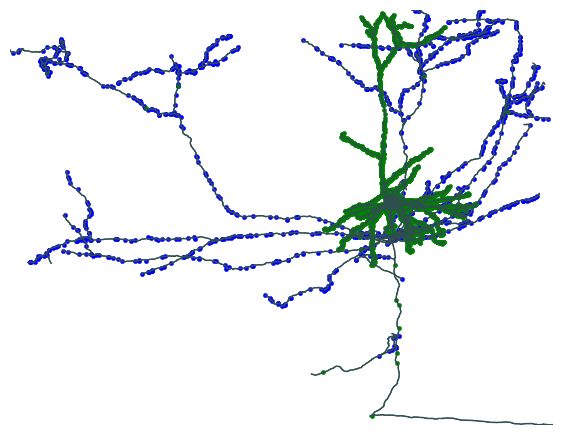

In [16]:
ax = plot_skeleton(sk)

sns.scatterplot(data=pre_syns, x="pre_pt_position_x", y="pre_pt_position_y", 
                s=10, color="b", ax=ax, edgecolor=None) 

sns.scatterplot(data=post_syns, x="post_pt_position_x", y="post_pt_position_y", 
                s=10, color="g", ax=ax, edgecolor=None) 

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

## Synapse matrix

The synapses of neurons create a network of synaptic connections. One way of visualizing this connectivity is in a matrix form. Pandas provides the `pivot_table` function that we can use to make a matrix out of the tabular synapse data. For now, we will limit ourselves to the synapses between the proofread neurons.
    
Each synapses has a `size` value assigned to it. How to aggregate the sizes from multiple synapes between two neurons depends on the research question. Synapse sizes vary by a lot and are related to the physiological strength of a synapse. In this notebook, we ignore the synapse size and only look at binary (connected yes/no) connectivity.

</d>

In [17]:
proof_proof_syn_table = filter_synapse_table(proof_syn_table, pre_root_ids=proof_df["pt_root_id"], post_root_ids=proof_df["pt_root_id"])

syn_mat = proof_proof_syn_table.pivot_table(index="pre_pt_root_id", columns="post_pt_root_id", 
                                            values="size", aggfunc=lambda x: float(np.sum(x) > 0)).fillna(0)

# Make matrix is quadratic
syn_mat = syn_mat.reindex(columns=np.array(syn_mat.index))

<Axes: xlabel='post_pt_root_id', ylabel='pre_pt_root_id'>

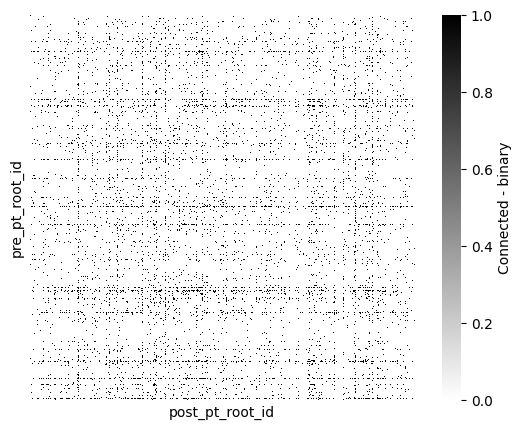

In [18]:
fig, ax = plt.subplots(figsize=(7, 5))
sns.heatmap(syn_mat, cmap="gray_r", xticklabels=[], yticklabels=[], 
            ax=ax, square=True,
            cbar_kws={"label": "Connected - binary"})

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

## Adding cell type information
    
The synapse matrix above clearly contains a lot of information but no real structure is visible that we could interpret. Cell type information can help us to sort to this matrix and make connectivity patterns visible. 
    
Cell types can be assigned based on different features of a cell and come with different levels of resolution. The cell types we will be using here at first were manually assigned by experts and represent an intermediate level of resolution in the cell type hierarchy.
    
In this notebook, we will focus on the excitatory neurons. The exercise notebook expands this to include inhibitory neurons.
    
</d>

In [19]:
cell_type_df = pd.read_feather(pjoin(data_root,"microns1078", "cell_types_microns_1078_manual.feather"))
cell_type_df = cell_type_df[cell_type_df["classification_system"] == "aibs_coarse_excitatory"]
cell_type_df = cell_type_df[cell_type_df["cell_type"] != "Unsure E"]
cell_type_df = cell_type_df[np.isin(cell_type_df["pt_root_id"], proof_df["pt_root_id"])]

In [20]:
cell_type_df["cell_type"].value_counts()

cell_type
23P      348
4P       266
5P-PT     38
5P-IT     25
6P-IT      3
6P-U       2
6P-CT      2
Name: count, dtype: int64

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

## Sorting the synapse matrix with cell types
    
Let's combine the synaptic connecitivity with the cell type information. Below we provide logic for sorting a connectivity matrix using a list of labels.    
    
</d>

In [21]:
def sort_matrix_by_types(mat: pd.DataFrame, 
                         labels: pd.DataFrame, 
                         label_type_col: str = "cell_type", 
                         label_id_col: str = "pt_root_id", 
                         post_labels: pd.DataFrame = None, 
                         post_label_type_col: str = None, 
                         post_label_id_col: str = None):
    """Sorts (synapse) matrix by labels.

    This function assumes a square synapse matrix!

    Args:
        mat: synapse matrix as pandas DataFrame
        labels: DataFrame with labels, e.g. the output of client.materialize.query_table('aibs_metamodel_celltypes_v661')
        label_type_col: column name in labels for cell types
        label_id_col: column name in labels for root ids
        post_labels: DataFrame with labels, e.g. the output of client.materialize.query_table('aibs_metamodel_celltypes_v661')
        post_label_type_col: column name in labels for cell types
        post_label_id_col: column name in labels for root ids

    Returns:
        mat_sorted: sorted matrix
        mat_labels: sorted labels; has the same length as matrix
    """
    
    if post_labels is None:
        post_labels = labels
    if post_label_type_col is None:
        post_label_type_col = label_type_col
    if post_label_id_col is None:
        post_label_id_col = label_id_col
        
    mat_sorted = mat.copy()
    
    pre_mat_labels = np.array(labels.set_index(label_id_col).loc[mat_sorted.index][label_type_col])
    pre_sorting = np.argsort(pre_mat_labels)

    post_mat_labels = np.array(post_labels.set_index(post_label_id_col).loc[mat_sorted.T.index][post_label_type_col])
    post_sorting = np.argsort(post_mat_labels)

    mat_sorted = mat_sorted.iloc[pre_sorting].T.iloc[post_sorting].T

    return mat_sorted, pre_mat_labels[pre_sorting], post_mat_labels[post_sorting]

In [22]:
ct_ct_syn_table = filter_synapse_table(proof_syn_table, pre_root_ids=cell_type_df["pt_root_id"], post_root_ids=cell_type_df["pt_root_id"])


syn_mat = ct_ct_syn_table.pivot_table(index="pre_pt_root_id", columns="post_pt_root_id", 
                                      values="size", aggfunc=lambda x: float(np.sum(x) > 0)).fillna(0)

syn_mat = syn_mat.reindex(columns=np.array(syn_mat.index))

In [23]:
syn_mat_ct, syn_mat_cell_types, _ = sort_matrix_by_types(syn_mat, cell_type_df)

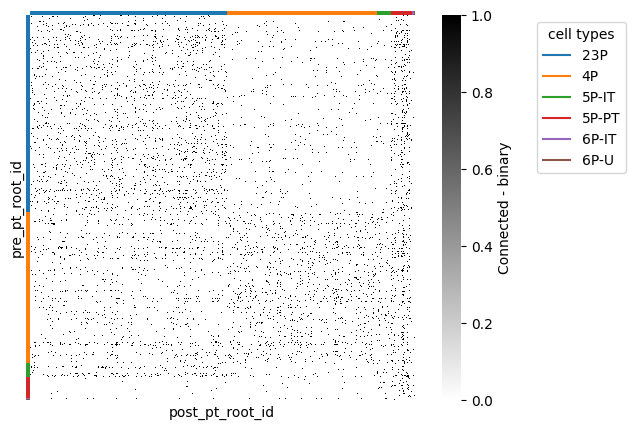

In [24]:
cts, ct_idx = np.unique(syn_mat_cell_types, return_inverse=True)
ct_colors = plt.get_cmap("tab10")(ct_idx)

fig, ax = plt.subplots(figsize=(7, 5))
sns.heatmap(syn_mat_ct, cmap="gray_r", xticklabels=[], yticklabels=[], 
            ax=ax, square=True,
            cbar_kws={"label": "Connected - binary"})


# Adding row and column colors for cell types
for i, color in enumerate(ct_colors):
    ax.add_patch(plt.Rectangle(xy=(-0.01, i), width=0.01, height=1, color=color, lw=0,
                               transform=ax.get_yaxis_transform(), clip_on=False, label=color))

for i, color in enumerate(ct_colors):
    ax.add_patch(plt.Rectangle(xy=(i, 1), height=0.01, width=1, color=color, lw=0,
                               transform=ax.get_xaxis_transform(), clip_on=False, label=color))    
# fig.legend()
from matplotlib.lines import Line2D
# add a legend for the cell types
legend_elements = [Line2D([0], [0], color=plt.get_cmap("tab10")(i), label=ct) for i, ct in enumerate(cts)]
plt.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(1.3, 1), title="cell types")


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

## Adding automatocally inferred cell type information
    
My limiting us to synapses between the proofread neurons, we ignore hundreds of outputs that we could analyze. However, annotating all cells in the dataset manually is a lot of work. To overcome this, we trained classifiers based on the manual features. The classification approach to predict the cell types used in this notebook is described <a href=https://www.biorxiv.org/content/10.1101/2022.07.20.499976v2.abstract>this paper </a>. This classifier predicts cell types based on the soma of a cell. This means that only cells with a soma in the dataset will have a cell type attached to it. Again, we will only focus on the excitatory neurons for now.
    
</d>

In [25]:
cell_type_file_path = pjoin(data_root,"microns1078","cell_types_microns_1078_auto.feather" )
post_cell_type_df = pd.read_feather(cell_type_file_path)
post_cell_type_df = post_cell_type_df[post_cell_type_df["classification_system"] == "excitatory_neuron"]

In [26]:
post_cell_type_df["cell_type"].value_counts()

cell_type
23P      19643
4P       14722
6P-IT    11636
5P-IT     7887
6P-CT     6755
5P-ET     2158
5P-NP      957
Name: count, dtype: int64

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

Let's revisit our neuron from earlier for which we plotted the synapses along the axon. We will now add the cell type information to the synapses.
    
</d>

In [27]:
root_id = proof_df.iloc[2]["pt_root_id"]

sk = load_cv_skeleton(root_id, cv_obj)
pre_syns = filter_synapse_table(proof_syn_table, pre_root_ids=[root_id])

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

`merge` allows us to combine two tables based on columns that match between them. We use `merge` on the root ids to add cell type information to the synapses. Not all synapses are onto a segment that has a cell body in the dataset. Here, we are adding an `Unknown` label to these synapses.
    
</d>

In [28]:
pre_syns_annot = pd.merge(pre_syns, post_cell_type_df[["pt_root_id", "cell_type"]], left_on="post_pt_root_id", right_on="pt_root_id", how="left")
pre_syns_annot["cell_type"].fillna("Unknown", inplace=True)
pre_syns_annot["cell_type"].value_counts()

cell_type
Unknown    552
23P        310
5P-IT       87
6P-IT       74
6P-CT       50
5P-ET       29
4P          26
5P-NP        4
Name: count, dtype: int64

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p><b>Task 2:</b> Use the `pre_syns_annot` table to plot the synapses along with the skeleton as we did before. Using the `hue` parameter of `sns.scatterplot`, color the synapses by cell type.
    
</div>

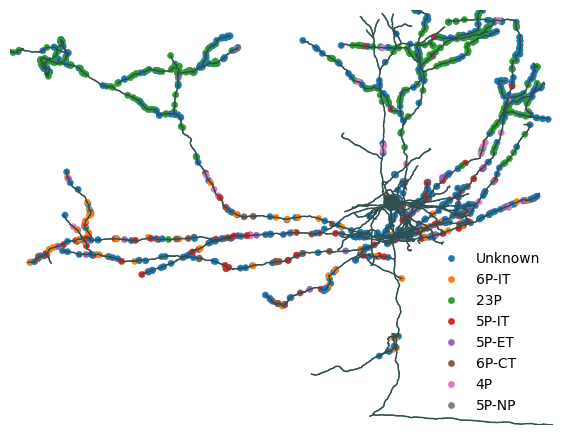

In [29]:
ax = plot_skeleton(sk)

sns.scatterplot(data=pre_syns_annot, x="pre_pt_position_x", y="pre_pt_position_y", 
                s=20, hue="cell_type", palette="tab10", ax=ax, edgecolor=None) 
ax.legend(frameon=False, loc="best")

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

## Extending the connectivity matrix
    
The automated cell type predictions allow us to extend the synapse matrix. This synapse matrix will now be rectangular because we have many more postsynaptic targets than presynaptic neurons.
    
</d>

In [30]:
ct_ct_syn_table = filter_synapse_table(proof_syn_table, pre_root_ids=cell_type_df["pt_root_id"], post_root_ids=post_cell_type_df["pt_root_id"])


syn_mat_rect = ct_ct_syn_table.pivot_table(index="pre_pt_root_id", columns="post_pt_root_id", 
                                      values="size", aggfunc=lambda x: float(np.sum(x) > 0)).fillna(0)


<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p><b>Task 3:</b> Use the plotting logic from above to plot the rectangular synaptic wiring diagram without cell type information.
    
</div>

<Axes: xlabel='post_pt_root_id', ylabel='pre_pt_root_id'>

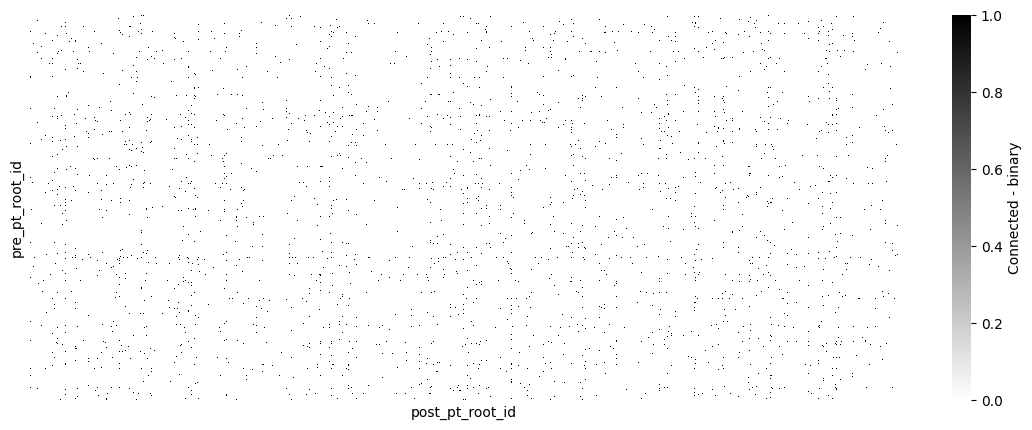

In [31]:
fig, ax = plt.subplots(figsize=(14, 5))
sns.heatmap(syn_mat_rect, cmap="gray_r", xticklabels=[], yticklabels=[], 
            ax=ax, square=False,
            cbar_kws={"label": "Connected - binary"})

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

Finally, we can use the automated cell type information to sort this matrix and plot it.
    
</d>

In [32]:
syn_mat_rect_ct, pre_syn_mat_cell_types, post_syn_mat_cell_types = sort_matrix_by_types(syn_mat_rect, cell_type_df, post_labels=post_cell_type_df)

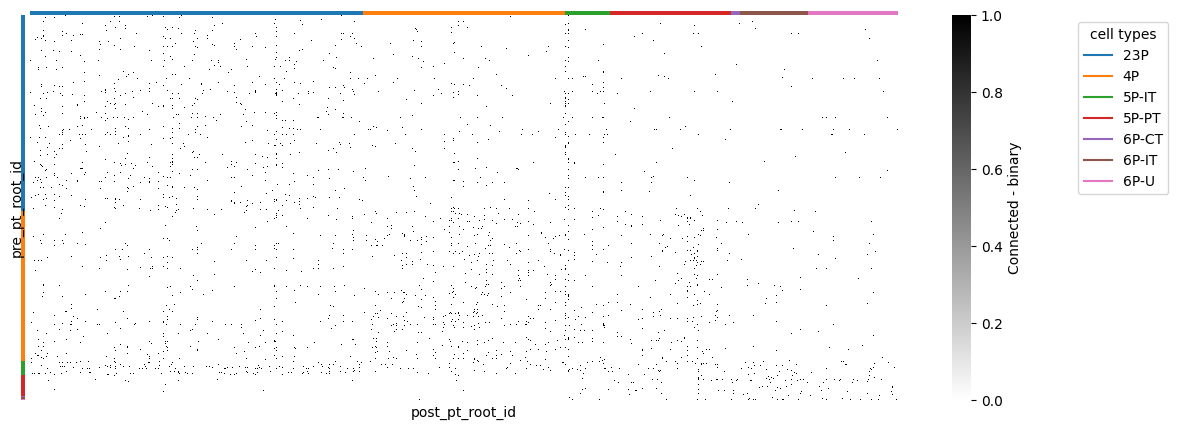

In [33]:
pre_cts, pre_ct_idx = np.unique(pre_syn_mat_cell_types, return_inverse=True)
row_ct_colors = plt.get_cmap("tab10")(pre_ct_idx)

post_cts, post_ct_idx = np.unique(post_syn_mat_cell_types, return_inverse=True)
col_ct_colors = plt.get_cmap("tab10")(post_ct_idx)

fig, ax = plt.subplots(figsize=(14, 5))
sns.heatmap(syn_mat_rect_ct, cmap="gray_r", xticklabels=[], yticklabels=[], 
            ax=ax, square=False,
            cbar_kws={"label": "Connected - binary"})

# Adding row and column colors for cell types
for i, color in enumerate(row_ct_colors):
    ax.add_patch(plt.Rectangle(xy=(-0.01, i), width=0.005, height=1, color=color, lw=0,
                               transform=ax.get_yaxis_transform(), clip_on=False))

for i, color in enumerate(col_ct_colors):
    ax.add_patch(plt.Rectangle(xy=(i, 1), height=0.01, width=1, color=color, lw=0,
                               transform=ax.get_xaxis_transform(), clip_on=False))    
from matplotlib.lines import Line2D
# add a legend for the cell types
legend_elements = [Line2D([0], [0], color=plt.get_cmap("tab10")(i), label=ct) for i, ct in enumerate(pre_cts)]
plt.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(1.2, 1), title="cell types")

